In [22]:
!pip install torch torchvision torchaudio
!pip install pycocotools
!pip install albumentations opencv-python matplotlib


In [23]:
!pip install pycocotools


In [24]:
import torch
print(torch.cuda.is_available())


False


In [25]:
!unzip -q RMDS_Segmentation_Assignment.zip -d /content/data


replace /content/data/__MACOSX/._test-30? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [26]:
!ls -R /content/data


/content/data:
__MACOSX  test-30  train-300  validation-300

/content/data/__MACOSX:
test-30  train-300  validation-300

/content/data/__MACOSX/test-30:

/content/data/__MACOSX/train-300:
data

/content/data/__MACOSX/train-300/data:

/content/data/__MACOSX/validation-300:
data

/content/data/__MACOSX/validation-300/data:

/content/data/test-30:
000000013177.jpg  000000153011.jpg  000000305317.jpg  000000449579.jpg
000000013291.jpg  000000156292.jpg  000000364297.jpg  000000456496.jpg
000000050380.jpg  000000161032.jpg  000000372349.jpg  000000489305.jpg
000000066771.jpg  000000169356.jpg  000000380913.jpg  000000489764.jpg
000000079969.jpg  000000233771.jpg  000000413552.jpg  000000491366.jpg
000000117525.jpg  000000273711.jpg  000000427655.jpg  000000574297.jpg
000000125850.jpg  000000281409.jpg  000000441442.jpg
000000143556.jpg  000000292415.jpg  000000443844.jpg

/content/data/train-300:
data  labels.json

/content/data/train-300/data:
000000004134.jpg  000000129945.jpg  0000002740

In [27]:
# Install dependencies

!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q pycocotools albumentations opencv-python matplotlib seaborn

In [28]:
# 1. Imports & utility functions

import os
import json
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from pycocotools.coco import COCO



In [29]:
# set random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', DEVICE)


Device: cpu


In [30]:
# 2. Paths

DATA_ROOT = '/content/data'  # default path in Colab after unzipping RMDS_Segmentation_Assignment.zip here
TRAIN_DIR = os.path.join(DATA_ROOT, 'train-300')
VAL_DIR = os.path.join(DATA_ROOT, 'validation-300')
TEST_DIR = os.path.join(DATA_ROOT, 'test-30')

print('Train dir exists?', os.path.exists(TRAIN_DIR))
print('Val dir exists?', os.path.exists(VAL_DIR))
print('Test dir exists?', os.path.exists(TEST_DIR))



Train dir exists? True
Val dir exists? True
Test dir exists? True


In [31]:
# 3. Defining target classes and helper to filter COCO annotations

TARGET_CLASSES = ['person', 'cat', 'sports ball', 'book']
# background will be 0, classes indexed 1..N
CAT_NAME_TO_LABEL = {name: idx+1 for idx, name in enumerate(TARGET_CLASSES)}
print('Class mapping:', CAT_NAME_TO_LABEL)


Class mapping: {'person': 1, 'cat': 2, 'sports ball': 3, 'book': 4}


In [32]:
# utility to load and filter COCO annotations

def load_and_filter_coco(coco_json_path, allowed_names=TARGET_CLASSES):
    coco = COCO(coco_json_path)
    # build mapping name->catId in coco json
    coco_cats = coco.loadCats(coco.getCatIds())
    name_to_id = {c['name']: c['id'] for c in coco_cats}
    allowed_cat_ids = [name_to_id[n] for n in allowed_names if n in name_to_id]
    # filter anns to only allowed
    img_ids = coco.getImgIds()
    filtered = {'images': [], 'annotations': [], 'categories': []}
    # copy categories filtered
    for c in coco_cats:
        if c['id'] in allowed_cat_ids:
            filtered['categories'].append(c)
    # collect images and filtered annotations
    ann_ids = coco.getAnnIds(catIds=allowed_cat_ids)
    anns = coco.loadAnns(ann_ids)
    img_ids_with_allowed = sorted(list(set([a['image_id'] for a in anns])))
    imgs = coco.loadImgs(img_ids_with_allowed)
    filtered['images'] = imgs
    filtered['annotations'] = anns
    return filtered



In [33]:
# 4. EDA

train_ann_path = os.path.join(TRAIN_DIR, 'labels.json')
val_ann_path = os.path.join(VAL_DIR, 'labels.json')

train_filtered = load_and_filter_coco(train_ann_path)
val_filtered = load_and_filter_coco(val_ann_path)

print(f"Train images (filtered): {len(train_filtered['images'])}")
print(f"Train annotations (filtered): {len(train_filtered['annotations'])}")
print(f"Val images (filtered): {len(val_filtered['images'])}")


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Train images (filtered): 300
Train annotations (filtered): 1310
Val images (filtered): 300


In [34]:
# class frequency

def class_counts(filtered):
    cnt = Counter()
    for a in filtered['annotations']:
        cnt[a['category_id']] += 1
    return cnt

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Train class counts (filtered): {'cat': 27, 'person': 1137, 'book': 128, 'sports ball': 18}


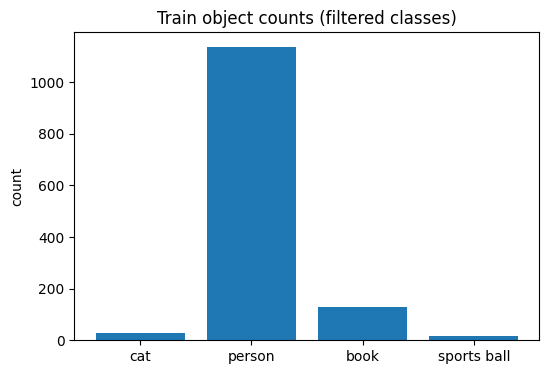

In [35]:
# mapping coco cat id -> name
coco_train = COCO(train_ann_path)
catid2name = {c['id']: c['name'] for c in coco_train.loadCats(coco_train.getCatIds())}

train_counts = class_counts(train_filtered)
train_counts_named = {catid2name[k]: v for k, v in train_counts.items()}
print('Train class counts (filtered):', train_counts_named)

plt.figure(figsize=(6,4))
plt.bar(list(train_counts_named.keys()), list(train_counts_named.values()))
plt.title('Train object counts (filtered classes)')
plt.ylabel('count')
plt.show()

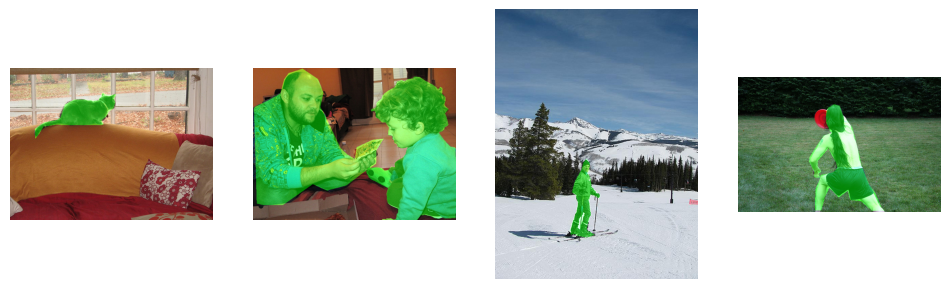

In [36]:
# show some sample images with masks

def show_sample_images(filtered, images_dir, n=4):
    imgs = filtered['images']
    anns = filtered['annotations']
    img_by_id = {img['id']: img for img in imgs}
    anns_by_img = {}
    for a in anns:
        anns_by_img.setdefault(a['image_id'], []).append(a)
    sampled = random.sample(list(img_by_id.keys()), min(n, len(img_by_id)))
    plt.figure(figsize=(12,6))
    for i, img_id in enumerate(sampled):
        info = img_by_id[img_id]
        path = os.path.join(images_dir, info['file_name'])
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # overlay masks
        for a in anns_by_img.get(img_id, []):
            mask = coco_train.annToMask(a)
            colored = np.zeros_like(img)
            colored[:,:,1] = (mask*255).astype(np.uint8)
            img = cv2.addWeighted(img, 1.0, colored, 0.5, 0)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

show_sample_images(train_filtered, os.path.join(TRAIN_DIR, 'data'), n=4)


In [37]:
# 5. Dataset class (PyTorch) COCO filtered

class FilteredCocoDataset(Dataset):
    def __init__(self, images_dir, ann_file, transforms=None):
        self.images_dir = Path(images_dir)
        self.coco = COCO(ann_file)
        # filter to allowed cat names
        cats = self.coco.loadCats(self.coco.getCatIds())
        cat_name_to_id = {c['name']: c['id'] for c in cats}
        allowed_cat_ids = [cat_name_to_id[n] for n in TARGET_CLASSES if n in cat_name_to_id]
        ann_ids = self.coco.getAnnIds(catIds=allowed_cat_ids)
        anns = self.coco.loadAnns(ann_ids)
        img_ids = sorted(list(set([a['image_id'] for a in anns])))
        self.img_ids = img_ids
        self.transforms = transforms
        # mapping coco cat id -> our label index
        self.coco_catid_to_label = {}
        for c in cats:
            if c['name'] in CAT_NAME_TO_LABEL:
                self.coco_catid_to_label[c['id']] = CAT_NAME_TO_LABEL[c['name']]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        path = self.images_dir / info['file_name']
        img = cv2.imread(str(path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        masks = []
        for a in anns:
            if a['category_id'] not in self.coco_catid_to_label:
                continue
            x,y,w,h = a['bbox']
            boxes.append([x, y, x+w, y+h])
            labels.append(self.coco_catid_to_label[a['category_id']])
            masks.append(self.coco.annToMask(a))

        if len(boxes) == 0:
            boxes = torch.zeros((0,4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, info['height'], info['width']), dtype=torch.uint8)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.stack(masks, axis=0), dtype=torch.uint8)

        img_tensor = torch.from_numpy(img.astype(np.float32)/255.).permute(2,0,1)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = torch.tensor([img_id])
        target['area'] = (boxes[:,3]-boxes[:,1])*(boxes[:,2]-boxes[:,0]) if boxes.shape[0]>0 else torch.zeros((0,))
        target['iscrowd'] = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        return img_tensor, target


In [38]:
# collate fn

def collate_fn(batch):
    return tuple(zip(*batch))


In [39]:
# 6. Build dataloaders

train_dataset = FilteredCocoDataset(os.path.join(TRAIN_DIR, 'data'), train_ann_path)
val_dataset = FilteredCocoDataset(os.path.join(VAL_DIR, 'data'), val_ann_path)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=1)

print('Train samples:', len(train_dataset))
print('Val samples:', len(val_dataset))


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Train samples: 300
Val samples: 300


In [40]:
# 7. Model setup: Mask R-CNN with custom heads

def get_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden, num_classes)
    return model

NUM_CLASSES = len(TARGET_CLASSES)+1  # background + targets
model = get_model(NUM_CLASSES)
model.to(DEVICE)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
# 8. Training loop

optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        images = list(img.to(DEVICE) for img in images)
        targets = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k,v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()
        if i % 50 == 0:
            print(f"Epoch {epoch} Iter {i} Loss {losses.item():.4f}")
    avg = epoch_loss / len(train_loader)
    print(f"Epoch {epoch} average loss {avg:.4f}")
    # save checkpoint
    torch.save(model.state_dict(), f"/content/maskrcnn_epoch{epoch}.pth")


Epoch 0 Iter 0 Loss 5.0032


In [ ]:
# 9. Simple evaluation: visualize predictions on validation images

model.eval()

def visualize_prediction(img_tensor, output, score_thresh=0.5):
    img = (img_tensor.cpu().permute(1,2,0).numpy()*255).astype(np.uint8).copy()
    h,w,_ = img.shape
    boxes = output['boxes'].cpu().numpy()
    labels = output['labels'].cpu().numpy()
    scores = output['scores'].cpu().numpy()
    masks = output['masks'].cpu().numpy()  # Nx1xH x W
    for box, lab, sc, mask in zip(boxes, labels, scores, masks):
        if sc < score_thresh:
            continue
        x1,y1,x2,y2 = box.astype(int)
        cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
        clsname = TARGET_CLASSES[lab-1] if lab-1 < len(TARGET_CLASSES) else str(lab)
        cv2.putText(img, f"{clsname}:{sc:.2f}", (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
        m = (mask[0] > 0.5).astype(np.uint8)
        colored = np.zeros_like(img)
        colored[:,:,2] = (m*255).astype(np.uint8)
        img = cv2.addWeighted(img, 1.0, colored, 0.5, 0)
    return img

# visualizing the first 6 val images
cnt=0
for images, targets in val_loader:
    images = list(img.to(DEVICE) for img in images)
    outputs = model(images)
    img_vis = visualize_prediction(images[0].cpu(), outputs[0], score_thresh=0.5)
    plt.figure(figsize=(6,6))
    plt.imshow(img_vis)
    plt.axis('off')
    plt.show()
    cnt+=1
    if cnt>=6:
        break


In [ ]:
# Running inference on 3 test images and saving results
# preparing test images list

test_images_dir = os.path.join(TEST_DIR, 'data')
all_test_files = sorted([f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg','.png'))])
selected = all_test_files[:3]

out_dir = '/content/test_predictions'
os.makedirs(out_dir, exist_ok=True)

for fn in selected:
    path = os.path.join(test_images_dir, fn)
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tensor = torch.from_numpy(img_rgb.astype(np.float32)/255.).permute(2,0,1).to(DEVICE)
    model.eval()
    with torch.no_grad():
        out = model([tensor])[0]
    vis = visualize_prediction(tensor.cpu(), out, score_thresh=0.4)
    save_path = os.path.join(out_dir, 'pred_'+fn)
    cv2.imwrite(save_path, cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))
    print('Saved', save_path)

print('Done. Download predictions from', out_dir)
